Data Normalization
----

Normalization and transformation with **shifted logarithm** and analytical pearson residual.

Normalizing is done accoring to: https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html

Output:

- `VERSION}_adata_filtered_and_doublet_corrected_counts_norm.h5ad`

## Dependecy notebooks

Assumes quality control is finished:

- `02_quality_control.ipynb`
- `04_doublet_detection.ipynb`

Load data: `{VERSION}_adata_doublet_filtered`

## Import packages

If you want modules to be automatically reloaded when you call them, use `autoreload`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print("Python executable:", sys.executable)
print("Python path:", sys.path[:3])  # First few paths

Python executable: /ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/preprocessing/bin/python
Python path: ['/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/preprocessing/lib/python312.zip', '/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/preprocessing/lib/python3.12', '/ictstr01/groups/ml01/workspace/francesca.drummer/mamba/envs/preprocessing/lib/python3.12/lib-dynload']


Import packages

In [3]:
# import standard packages

import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from pathlib import Path

# import single-cell packages
import scanpy as sc

### For scran normalization ####
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

rcb.logger.setLevel(logging.ERROR)
pandas2ri.activate()
# anndata2ri.activate() -> throws error when do activate

%load_ext rpy2.ipython

from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter

%load_ext rpy2.ipython

# set verbosity levels
sc.settings.verbosity = 2

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [4]:
#sc.logging.print_versions()

## Set up paths

Define global paths.

In [5]:
sys.path.insert(0, "../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, RESULTS_DIR, FIG_DIR

Set up the paths to save figures.

In [6]:
sc.settings.figdir = str(FIG_DIR)
#scv.settings.figdir = str(FIG_DIR)
#cr.settings.figdir = str(FIG_DIR)

## Set global parameters

Set some plotting parameters.

In [7]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.
SMALL_SIZE = 17
MEDIUM_SIZE = 19
BIGGER_SIZE = 21
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

If there are other global parameters for this analysis, put them here as well. 

## Define utility functions

Any utility functions you may need in this notebook go here. 

In [8]:
from utils.utils import SAMPLES, VERSION

# Load the data

In [9]:
adata = sc.read(DATA_DIR / f"{VERSION}_adata_doublet_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 35344 × 34859
    obs: 'sample', 'condition', 'area', 'age', 'donor', 'sequencing batch', 'sequencing id', 'sex', 'APOE genotype', 'brain area number', 'running number', 'donor_v2', 'donor_v2_area', 'n_counts', 'log_counts', 'n_genes', 'tech_sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_nuclear', 'log1p_total_counts_nuclear', 'pct_counts_nuclear', 'braak_stage', 'area_abbrev', 'condition_area', 'brainbank', 'brain_area_latin', 'soupx_groups', 'scDblFinder_score', 'scDblFinder_class', 'leiden', 'mt_groups'
    var: 'ensemble_id', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'ribo', 'hb', 'nuclear', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'area_colors', 'brain area latin_colors', 'cell_type_sea_colors', 'condition_colo

In [21]:
adata.X = adata.layers['raw']

In [22]:
brain_area_abbrev = {
    'Area Striata': 'AS',  # Visual Cortex
    'Gyrus Rectus': 'GR',  # Prefrontal Cortex
    'Temporal Gyrus': 'TG'  # Temporal Cortex
}


adata.obs['tech_sample_2'] = (
    adata.obs['donor_v2'].astype(str) + 
    ' - ' 
    + adata.obs['brain_area_latin'].astype(str).replace(brain_area_abbrev)
).astype('category')

# Normalize data

Normalization + Shifted logarithm transformation

In [23]:
#keep raw and depth-normalized counts for later
adata.layers['raw'] = adata.X.copy()
adata.layers['norm'] = sc.pp.normalize_total(adata, inplace=False)['X']
adata.layers['log1p_norm'] = np.log1p(sc.pp.normalize_total(adata, inplace=False)['X'])

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


Pearson residuals normalization

In [24]:
from scipy.sparse import csr_matrix, issparse

# compute pearson residuals
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata, inplace = False)
adata.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

computing analytic Pearson residuals on adata.X
    finished (0:00:27)


### Scran normalization

In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse import issparse

In [11]:
%%R
library(scran)
library(BiocParallel)

In [12]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(
    adata_pp, key_added="groups", flavor="igraph", n_iterations=2, directed=False
)

normalizing counts per cell
    finished (0:00:02)
computing PCA
    with n_comps=15
    finished (0:00:57)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished (0:00:40)
running Leiden clustering
    finished (0:00:02)


In [15]:
data_mat = adata_pp.X.T
# convert to CSC if possible. See https://github.com/MarioniLab/scran/issues/70
if issparse(data_mat):
    if data_mat.nnz > 2**31 - 1:
        data_mat = data_mat.tocoo()
    else:
        data_mat = data_mat.tocsc()
    # Convert sparse matrix to dense numpy array
    data_mat = data_mat.toarray()

with localconverter(ro.default_converter + numpy2ri.converter):
    ro.globalenv["data_mat"] = data_mat

with localconverter(ro.default_converter + pandas2ri.converter):
    ro.globalenv["input_groups"] = adata_pp.obs["groups"]

In [16]:
del adata_pp

In [17]:
%%R -o size_factors

size_factors = sizeFactors(
    computeSumFactors(
        SingleCellExperiment(
            list(counts=data_mat)), 
            clusters = input_groups,
            min.mean = 0.1,
            BPPARAM = MulticoreParam()
    )
)

In [18]:
adata.obs["size_factors"] = size_factors
scran = adata.X / adata.obs["size_factors"].values[:, None]
scran_logged = np.log1p(scran)
adata.layers["scran_normalization"] = csr_matrix(scran_logged)

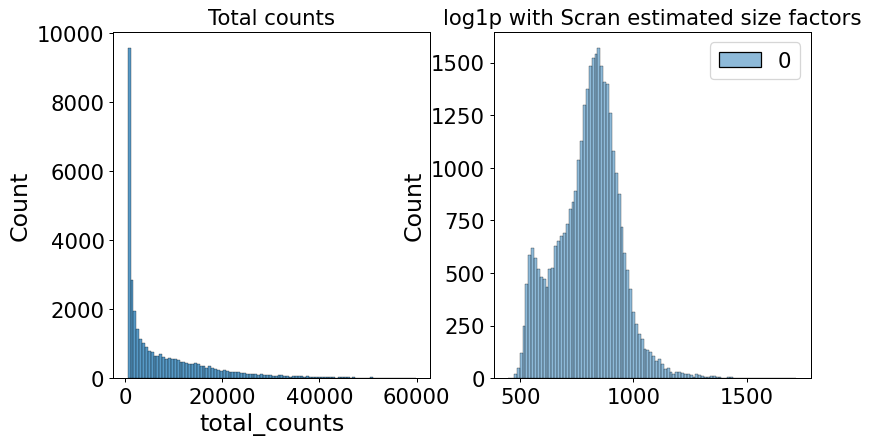

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[1]
)
axes[1].set_title("log1p with Scran estimated size factors")
plt.show()

## Visualize normalized data

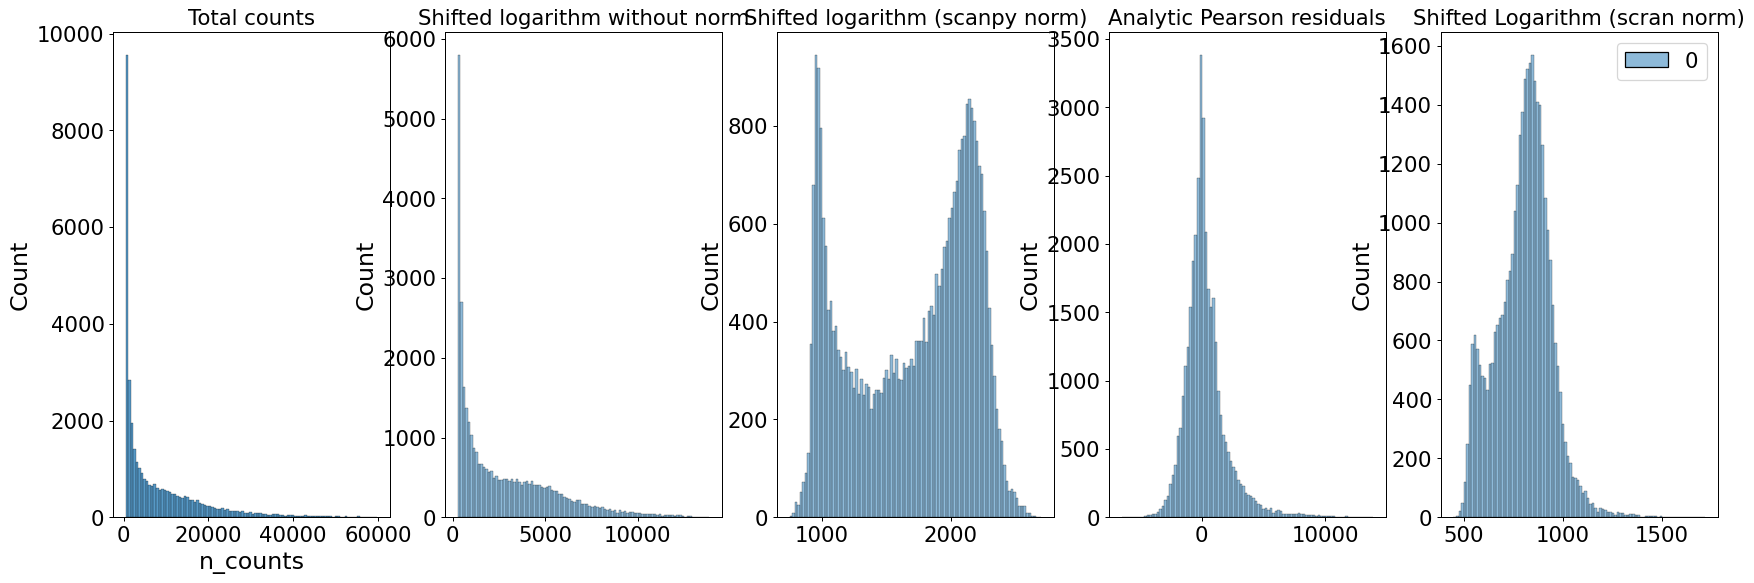

In [35]:
fig, axes = plt.subplots(1, 5, figsize=(23, 7))
p1 = sns.histplot(adata.obs["n_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["X_log"].sum(1), bins=100, kde=False, ax=axes[1], legend = False)
axes[1].set_title("Shifted logarithm without norm")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[2], legend = False)
axes[2].set_title("Shifted logarithm (scanpy norm)")
p3 = sns.histplot(adata.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[3], legend = False)
axes[3].set_title("Analytic Pearson residuals")
p4 = sns.histplot(adata.layers["scran_normalization"].sum(1), bins=100, kde=False, ax=axes[4])
axes[4].set_title("Shifted Logarithm (scran norm)")
plt.show()

**Shifted logarithm without norm**:
- np.log1p(adata.X)
- heavy-right tail

**Shifted logarithm - scanpy norm**:
- bimodal distirbution
- Reasonable value range (~1000-2500) - not too compressed, preserving dynamic range for downstream analysis

**Shifted logarithm - scran norm**:
- Highly skewed distribution - heavily right-skewed
- compressed range (500-1500) could make it harder to detect differential expression

## shifted logarithm

sc.pp.normalize + log1p

In [17]:
adata.X = adata.layers["log1p_norm"]

In [18]:
adata.obs['log1p_counts'] = adata.layers["log1p_norm"].sum(1)

### Dimensionality reduction (PCs = 30, NN = 15)

In [19]:
sc.tl.pca(adata,n_comps=30)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=30
    finished (0:00:24)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:03)
running Leiden clustering
    finished (0:00:15)
computing UMAP
    finished (0:00:19)


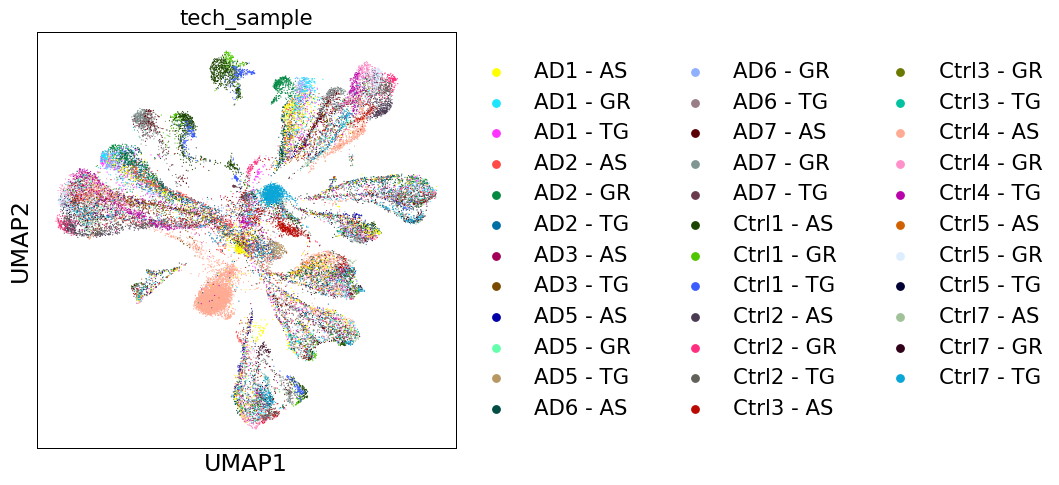

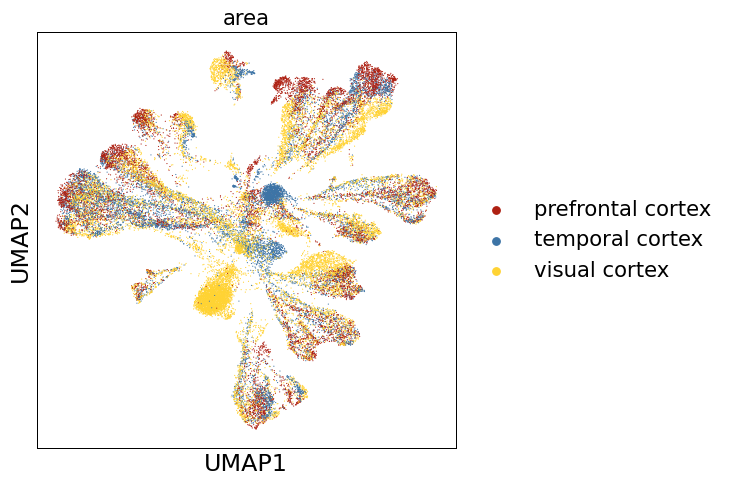

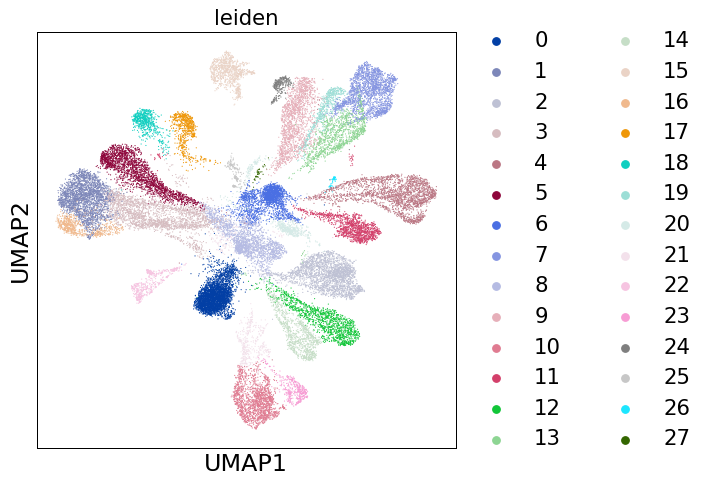

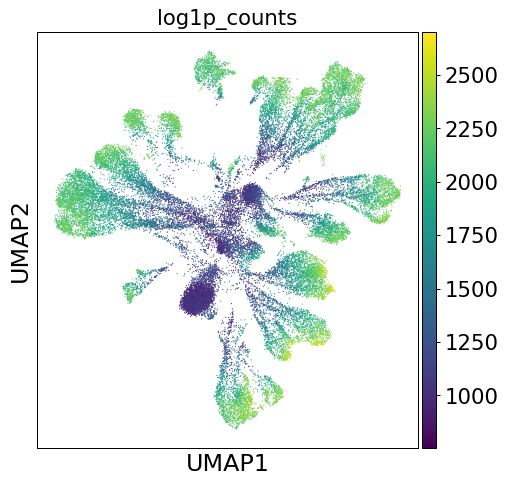

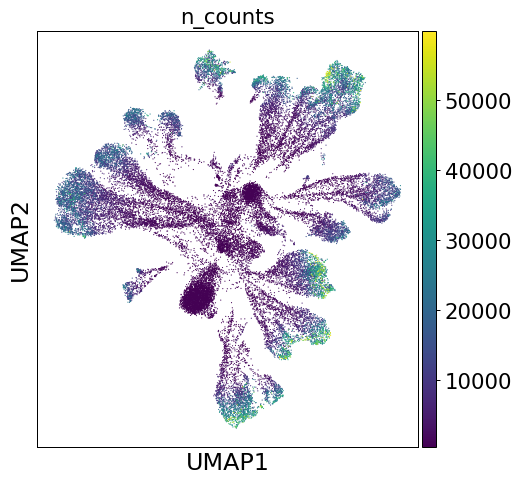

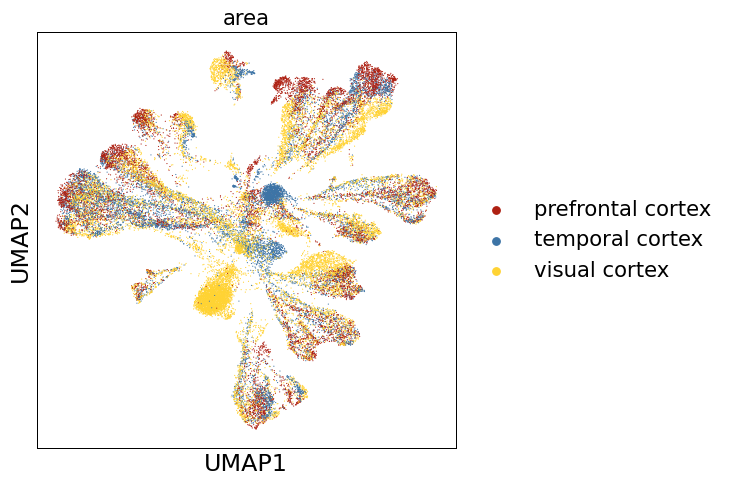

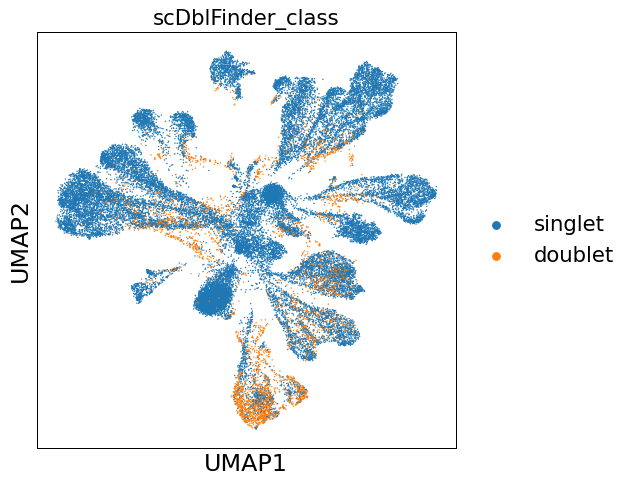

In [20]:
plt.rcParams['figure.figsize']= (6, 6)
p1 = sc.pl.umap(adata, color=['tech_sample'])
p1 = sc.pl.umap(adata, color=['area'])
p2 = sc.pl.umap(adata, color=['leiden'])
p3 = sc.pl.umap(adata, color=['log1p_counts'])
p3 = sc.pl.umap(adata, color=['n_counts'])
p3 = sc.pl.umap(adata, color=['area'])
p4 = sc.pl.umap(adata, color=['scDblFinder_class'], sort_order=False, s=5)

### Dimensionality reduction (PCs = 50, NN = 15)

In [21]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

computing PCA
    with n_comps=50
    finished (0:00:39)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)
running Leiden clustering
    finished (0:00:21)
computing UMAP
    finished (0:00:20)


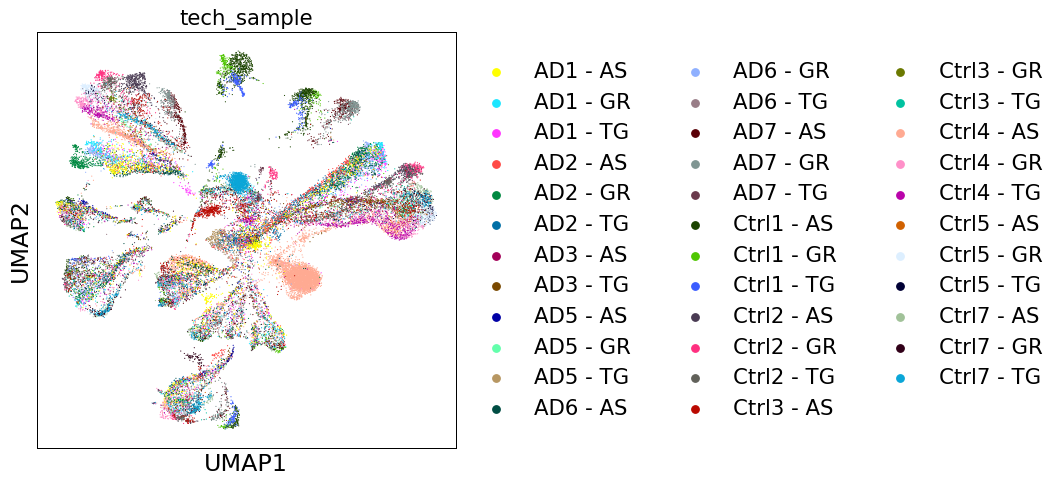

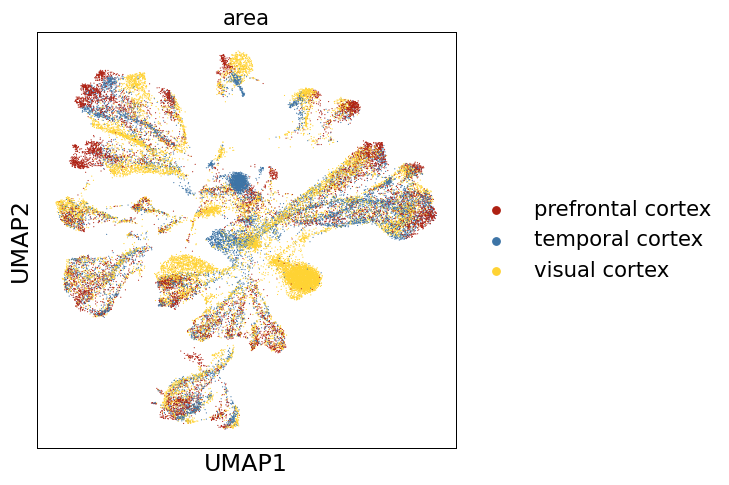

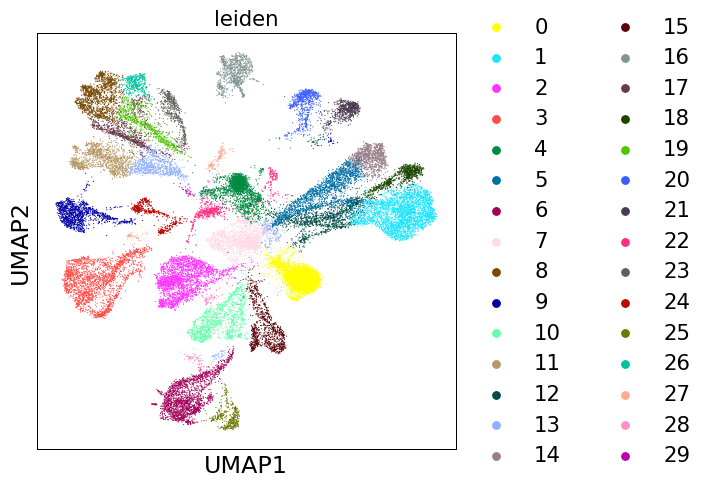

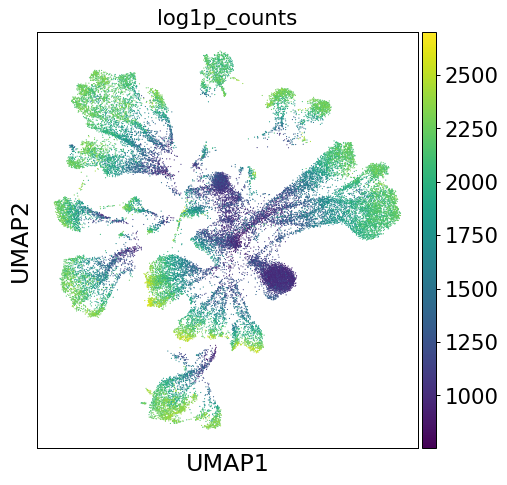

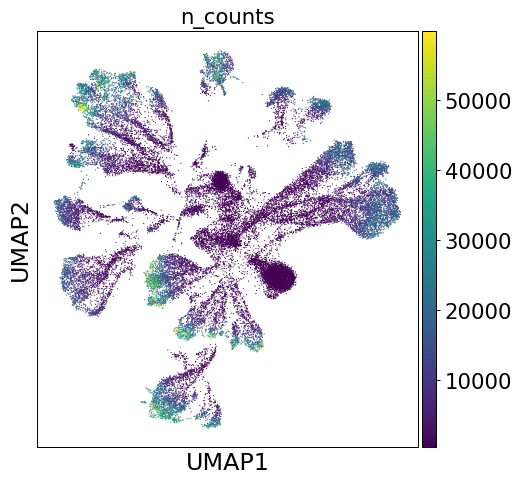

In [22]:
plt.rcParams['figure.figsize']= (6, 6)
p1 = sc.pl.umap(adata, color=['tech_sample'])
p1 = sc.pl.umap(adata, color=['area'])
p2 = sc.pl.umap(adata, color=['leiden'])
p3 = sc.pl.umap(adata, color=['log1p_counts'])
p3 = sc.pl.umap(adata, color=['n_counts'])

## Normalize with gene subset

## Save normalized data

In [32]:
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
adata.write(Path(DATA_DIR / f"{VERSION}_adata_preprocessed_norm.h5ad"))